In [47]:
import colorsys as cs
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image,ImageEnhance
from skimage import data
from scipy import misc
 

In [ ]:
source = Image.open('cat_test.jpeg')
template = Image.open('cat_test2.jpg') 
sd = data.coffee()
np.asarray(source)

In [ ]:
rgb_image_source = np.asarray(source)
hls_image = [[ list(cs.rgb_to_hls(*rgb/255)) for rgb in row] for row in rgb_image]

In [21]:
def hls_to_rgb(r, g, b):
  return[ color * 255 for color in list(cs.hls_to_rgb(r,g,b))]
 

def adjust_hls(image, hue=1, light=1, saturation=1):
  hls_image = [[list(cs.rgb_to_hls(*rgb/255)) for rgb in row] for row in image]
  hls_adjusted_image = [[[hls[0]*hue,hls[1]*light,hls[2]*saturation] for hls in row] for row in hls_image]
  back_to_rgb = [[ np.asarray(hls_to_rgb(*rgb)).astype(int) for rgb in row] for row in hls_adjusted_image]
  return back_to_rgb

def match_cdf(source):
  values,unique_indices,counts = np.unique(source.ravel(),return_inverse = True, return_counts = True)
  return values,unique_indices,counts
  

In [ ]:
def _match_cumulative_cdf(source, template):
    """
    Return modified source array so that the cumulative density function of
    its values matches the cumulative density function of the template.
    """
    rgb_image_source = np.array(source)
    rgb_image_template = np.array(template)
    src_values, src_unique_indices, src_counts = np.unique(rgb_image_source.ravel(),return_inverse=True,return_counts=True)
    tmpl_values, tmpl_counts = np.unique(rgb_image_template.ravel(), return_counts=True)

    # calculate normalized quantiles for each array
    src_quantiles = np.cumsum(src_counts) / rgb_image_source.size
    tmpl_quantiles = np.cumsum(tmpl_counts) / rgb_image_template.size

    # print(src_quantiles)

    interp_a_values = np.interp(tmpl_values, src_quantiles,tmpl_quantiles)
    print(interp_a_values)
    print(interp_a_values[src_unique_indices])
    return interp_a_values[src_unique_indices].reshape(rgb_image_source.shape)

In [ ]:
source1 = Image.open('source.png')
reference = Image.open('reference.png')
source = Image.open('cat_test.jpeg')
template = Image.open('cat_test2.jpg') 
matched = _match_cumulative_cdf(source, source)
# out_dtype = utils._supported_float_type(image.dtype)

#matched_rgb = [[ list(cs.hls_to_rgb(*hls)) for hls in row] for row in matched]
#matched.astype(out_dtype, copy=False)
plt.imshow(matched)


In [ ]:
source1 = misc.imread('reference.png')

In [ ]:
rgb_bright = adjust_hls(rgb_image)
image2 = plt.imshow(rgb_bright)
image2

In [169]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
        
    template = np.array([[ list(cs.rgb_to_hls(*rgb/255)) for rgb in row] for row in template])
    template_h = np.array(template[list(range(0,len(template))),:,0]).ravel()
    template_l = np.array(template[list(range(0,len(template))),:,1]).ravel()
    template_s = np.array(template[list(range(0,len(template))),:,2]).ravel()
    
    source = np.array([[ list(cs.rgb_to_hls(*rgb/255)) for rgb in row] for row in source])
    source_h = np.array(source[list(range(0,len(source))),:,0]).ravel()
    print(source_h)
    source_l = np.array(source[list(range(0,len(source))),:,1]).ravel()
    source_s = np.array(source[list(range(0,len(source))),:,2]).ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values_h, bin_idx_h, s_counts_h = np.unique(source_h, return_inverse=True,
                                            return_counts=True)
    t_values_h, t_counts_h = np.unique(template_h, return_counts=True)
    
    s_values_l, bin_idx_l, s_counts_l = np.unique(source_l, return_inverse=True,
                                            return_counts=True)
    t_values_l, t_counts_l = np.unique(template_l, return_counts=True)
    
    s_values_s, bin_idx_s, s_counts_s = np.unique(source_s, return_inverse=True,
                                            return_counts=True)
    t_values_s, t_counts_s = np.unique(template_s, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles_h = np.cumsum(s_counts_h).astype(np.float64)
    s_quantiles_h /= s_quantiles_h[-1]
    t_quantiles_h = np.cumsum(t_counts_h).astype(np.float64)
    t_quantiles_h /= t_quantiles_h[-1]
    
    s_quantiles_l = np.cumsum(s_counts_l).astype(np.float64)
    s_quantiles_l /= s_quantiles_l[-1]
    t_quantiles_l = np.cumsum(t_counts_l).astype(np.float64)
    t_quantiles_l /= t_quantiles_l[-1]

    s_quantiles_s = np.cumsum(s_counts_s).astype(np.float64)
    s_quantiles_s /= s_quantiles_s[-1]
    t_quantiles_s = np.cumsum(t_counts_s).astype(np.float64)
    t_quantiles_s /= t_quantiles_s[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values_h = np.interp(s_quantiles_h, t_quantiles_h, t_values_h)
    interp_t_values_l = np.interp(s_quantiles_l, t_quantiles_l, t_values_l)
    interp_t_values_s = np.interp(s_quantiles_s, t_quantiles_s, t_values_s)
    
    new_h = interp_t_values_h[bin_idx_h]
    new_l = interp_t_values_l[bin_idx_l]
    new_s = interp_t_values_s[bin_idx_s]
#     new_h = source_h
#     new_l = source_l
#     new_s = source_s
    print(len(new_h), len(new_l), len(new_s))
    new_values = [None]*(len(new_h)+len(new_s)+len(new_s))
    new_values[::3] = new_h
    new_values[1::3] = new_l
    new_values[2::3] = new_s
    print(len(new_values))
    new_shape = np.array(new_values).reshape(oldshape)
    rgb = np.array([[ np.asarray(hls_to_rgb(*rgb)).astype(int) for rgb in row] for row in new_shape])

    return rgb

[0.21212121 0.21212121 0.21212121 ... 0.02777778 0.02777778 0.02777778]
50625 50625 50625
151875


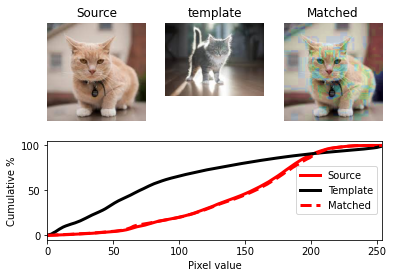

In [171]:
from matplotlib import pyplot as plt
from matplotlib import image as img

source = img.imread('cat_test.jpeg')
template = img.imread('cat_test2.jpg')
np.asarray(source)
np.asarray(template)
matched = hist_match(source, template).astype(int)

def ecdf(x):
    """convenience function for computing the empirical CDF"""
    vals, counts = np.unique(x, return_counts=True)
    ecdf = np.cumsum(counts).astype(np.float64)
    ecdf /= ecdf[-1]
    return vals, ecdf

x1, y1 = ecdf(source.ravel())
x2, y2 = ecdf(template.ravel())
x3, y3 = ecdf(matched.ravel())

fig = plt.figure()
gs = plt.GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharex=ax1, sharey=ax1)
ax4 = fig.add_subplot(gs[1, :])
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(source, cmap=plt.cm.gray)
ax1.set_title('Source')
ax2.imshow(template, cmap=plt.cm.gray)
ax2.set_title('template')
ax3.imshow(matched, cmap=plt.cm.gray)
ax3.set_title('Matched')

ax4.plot(x1, y1 * 100, '-r', lw=3, label='Source')
ax4.plot(x2, y2 * 100, '-k', lw=3, label='Template')
ax4.plot(x3, y3 * 100, '--r', lw=3, label='Matched')
ax4.set_xlim(x1[0], x1[-1])
ax4.set_xlabel('Pixel value')
ax4.set_ylabel('Cumulative %')
ax4.legend(loc=5)

In [89]:
test = np.array(source).ravel()
print(len(test[::3]))
len(test[1::3])
len(test[2::3])

50625


50625

In [105]:
len(np.array(source[list(range(0,len(source))),:,0]).ravel())

50625

In [145]:
source1 = np.array([[ list(cs.rgb_to_hls(*rgb/255)) for rgb in row] for row in source])
source_h = np.array(source1[list(range(0,len(source1))),:,0]).ravel()
temp1 = np.array([[ list(cs.rgb_to_hls(*rgb/255)) for rgb in row] for row in template])
temp_h = np.array(temp1[list(range(0,len(temp1))),:,0]).ravel()

In [147]:
len(source_h)

50625

In [152]:
len(source1.ravel()) / 3

50625.0